In [171]:
import sys  
import time  
import math  
import uuid  
import numpy as np  
import matplotlib.pyplot as plt
import pickle
import networkx as nx
from numpy import errstate  
from sklearn.datasets import fetch_openml  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder  

In [172]:
sys.setrecursionlimit(10000)  

In [173]:
class VarValue:
    def __init__(self, value, children=(), varname=''):
        self.varname = varname
        self.value = value
        self.derivative_to = {}
        self.children = children

    def __chain_rule(self, dSelfdx, child):
        if(child.varname[:5] != 'const'):
            for grandchild_varname in child.derivative_to:
                if(grandchild_varname != 'const'):
                    if(grandchild_varname in self.derivative_to):

                        self.derivative_to[grandchild_varname] += dSelfdx * child.derivative_to[grandchild_varname]
                    else:
                        self.derivative_to[grandchild_varname] = dSelfdx * child.derivative_to[grandchild_varname]
            if(len(self.derivative_to) == 0):
              raise ValueError(self.varname, child.varname)

    def relu(self):
        out = VarValue(max(0,self.value), children=(self,), varname='out_relu_'+str(uuid.uuid4()))
        if(self.varname[:5] != 'const'):
            dodx = 0 if self.value <= 0 else 1
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out

    def ln(self):
        out = VarValue(math.log(self.value), children=(self,), varname='out_ln_'+str(uuid.uuid4()))
        if(self.varname[:5] != 'const'):
            dodx = 1/(self.value)
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out

    def __mul__(self, other):
        other = other if isinstance(other, VarValue) else VarValue(other, varname='const'+str(uuid.uuid4()))
        out = VarValue(self.value * other.value, children=(self, other), varname='out_mul_'+str(uuid.uuid4()))

        if(self.varname[:5] != 'const'):
            dodx1 = other.value
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx1
            else:
                out.__chain_rule(dodx1, self)
        if(other.varname[:5] != 'const'):
            dodx2 = self.value
            if(len(other.children) == 0):
                out.derivative_to[other.varname] = dodx2
            else:
                out.__chain_rule(dodx2, other)
        return out

    def __add__(self, other):
        other = other if isinstance(other, VarValue) else VarValue(other, varname='const'+str(uuid.uuid4()))
        out = VarValue(self.value + other.value, children=(self, other), varname='out_add_'+str(uuid.uuid4()))
        if(self.varname[:5] != 'const'):
            dodx1 = 1
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx1
            else:
                out.__chain_rule(dodx1, self)
        if(other.varname[:5] != 'const'):
            dodx2 = 1
            if(len(other.children) == 0):
                out.derivative_to[other.varname] = dodx2
            else:
                out.__chain_rule(dodx2, other)
        return out

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __pow__(self, other):
        other = other if isinstance(other, VarValue) else VarValue(other, varname='const'+str(uuid.uuid4()))
        try:
            with errstate(over='raise', invalid='raise'):
                result = float(self.value) ** float(other.value)
        except (OverflowError, FloatingPointError):
            if abs(float(self.value)) > 1:
                result = math.inf
            else:
                result = 0

        out = VarValue(result, children=(self, other), varname='out_pow_'+str(uuid.uuid4()))

        if(self.varname[:5] != 'const'):
            dodx = other.value * self.value**(other.value-1)
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return other + (-self)

    def __rpow__(self, other):
        other = other if isinstance(other, VarValue) else VarValue(other, varname='const'+str(uuid.uuid4()))
        out = VarValue(other.value**self.value, children=(self, other), varname='out_rpow_'+str(uuid.uuid4()))
        if self.varname:
            dodx = other.value**self.value * math.log(other.value)
            if(len(self.children) == 0):
                out.derivative_to[self.varname] = dodx
            else:
                out.__chain_rule(dodx, self)
        return out

    def __rtruediv__(self, other):
        return other * self**-1

    # Equality
    def __eq__(self, other):
        if isinstance(other, VarValue):
            return self.varname == other.varname
        return self.varname == other

    # Inequality
    def __ne__(self, other):
        return not self.__eq__(other)

    # Less than
    def __lt__(self, other):
        if isinstance(other, VarValue):
            return self.value < other.value
        return self.value < other

    # Less than or equal
    def __le__(self, other):
        if isinstance(other, VarValue):
            return self.value <= other.value
        return self.value <= other

    # Greater than
    def __gt__(self, other):
        if isinstance(other, VarValue):
            return self.value > other.value
        return self.value > other

    # Greater than or equal
    def __ge__(self, other):
        if isinstance(other, VarValue):
            return self.value >= other.value
        return self.value >= other

In [174]:
class Layer:
    def __init__(self,n_neurons=3, init='zero', activation='relu'):
        self.n_neurons = n_neurons
        self.current_input_batch = None
        self.init = init    # zero/uniform/normal - harusnya gaperlu disini, ini di layer langsung harusnya
        self.weights = None
        self.biases = None
        self.activation = activation    # linear/relu/sigmoid/tanh/softmax/binary_step/leaky_relu/prelu/elu/swish(ini)/gelu(ini)
        self.learning_rate = None

        self.net = None
        self.out = None

    def __update_weights_dEdW(self, dEdW):
        self.weights -= self.learning_rate*dEdW

    def __update_biases_dEdB(self, dEdB):
        self.biases -= self.learning_rate*dEdB

    def __update_weights_err_term(self, err_term):
        for input in self.current_input_batch:
            for i in self.weights:
                for j in i:
                    self.weights += self.learning_rate*err_term[j]*self.input[i]

    def __update_biases_err_term(self, err_term):
        for i in self.weights:
            for j in i:
                self.weights += self.learning_rate*err_term[j]*1

    def forward(self, current_input_batch):
        self.current_input_batch = current_input_batch

        if(self.weights is None):
            if(self.init == 'zero'):
                self.weights = np.array([[VarValue(0,varname='w_'+str(uuid.uuid4())) for _ in range(self.n_neurons)] for _ in range(len(self.current_input_batch[0]))])
                self.biases = np.array([VarValue(0,varname='b_'+str(uuid.uuid4())) for _ in range(self.n_neurons)])
            elif(self.init == 'uniform'):
                # TODO: Initialization uniform
                pass
            elif(self.init == 'normal'):
                # TODO: Initialization normal
                pass

        self.net = (np.dot(self.current_input_batch, self.weights)) + self.biases

        if(self.activation == 'linear'):
            self.out = self.net

        elif(self.activation == 'relu'):
            self.out = np.array([[net.relu() for net in row] for row in self.net])

        elif(self.activation == 'sigmoid'):
            for i in self.net:
                for j in i:
                    j.value = np.clip(j.value, -500, 500)
            self.out = 1 / (1 + (math.exp(1))**(-self.net))

        elif(self.activation == 'tanh'):
            self.out = (math.exp(1)**self.net - math.exp(1)**(-self.net))/(math.exp(1)**self.net + math.exp(1)**(-self.net))

    def backward(self, sum_err_term_k_w=None, err=None, method='instant_deriv'):
        
        if(method == 'instant_deriv'):

            dEdW = np.array([[ err.derivative_to[neuron_w.varname] for neuron_w in weights] for weights in self.weights])
            dEdB = np.array([ err.derivative_to[bias.varname] for bias in self.biases])

            self.__update_weights_dEdW(dEdW)
            self.__update_biases_dEdB(dEdB)

        else:
            # Versi pake Error Term - Not Tested Yet
            if(err):
                # Output Layer
                err_term = np.array([err.derivative_to[net.varname] for net in self.net])
            else:
                # Hidden Layer
                err_term = sum_err_term_k_w
                pass
            sum_err_term_w_current = self.weights @ err_term.T
            self.__update_weights_err_term(err_term)
            self.__update_biases_err_term(err_term)
            return sum_err_term_w_current,

    def clean_derivative(self):
        for input in self.current_input_batch:
            for x in input:
                x.derivative_to.clear()
                x.children = ()

        for i in self.weights:
            for j in i:
                j.derivative_to.clear()
                j.children = ()

        for b in self.biases:
            b.derivative_to ={}
            b.children = ()

        for i in self.net:
            for j in i:
                j.derivative_to.clear()
                j.children = ()

        for i in self.out:
            for j in i:
                j.derivative_to.clear()
                j.children = ()

In [ ]:
class FFNN:
    def __init__(self, loss='mse', batch_size=1, learning_rate=0.01, epochs=20, verbose=0):
        self.loss = loss    # mse/bce/cce
        self.batch_size=batch_size
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.verbose=verbose
        self.layers = None
        self.weights = []
        self.bias = []
        self.x = None
        self.y = None
        self.onehot_encoder = OneHotEncoder(categories='auto')

    def __loss(self, out, target):
        if(out.shape != target.shape):
            print("Output shape: ", out.shape)
            print("Target shape: ", target.shape)
            raise ValueError("Shape not match")
        if self.loss == 'mse':
            mse = (1/target.shape[1])*np.square(target - out)
            return np.sum(mse)
        elif self.loss == 'cce':
            epsilon = 1e-15
            out = np.clip(out, epsilon, 1 - epsilon)
            return -np.sum(target * np.log(out)) / self.batch_size

    def build_layers(self, *layers: Layer):
        self.layers = layers
        for layer in self.layers:
            layer.learning_rate = self.learning_rate

    def fit(self, x, y):
        self.x = x
        self.y = self.onehot_encoder.fit_transform(y.reshape(-1, 1))
        total_batch = (len(x)+self.batch_size-1)//self.batch_size
        start_global = time.time()
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}")
            start = time.time()
            count_batch = 1
            for i in range(total_batch):
                x_batch = self.x[i*self.batch_size:(i+1)*self.batch_size] if ((i+1) < total_batch) else self.x[i*self.batch_size:]
                y_batch = self.y[i*self.batch_size:(i+1)*self.batch_size] if ((i+1) < total_batch) else self.y[i*self.batch_size:]
                batch_input = x_batch
                for layer in self.layers:
                    layer.forward(batch_input)
                    batch_input = layer.out
                out = batch_input
                error = self.__loss(out, y_batch)
                count = 1

                for layer in self.layers[::-1]:
                    layer.backward(err=error)
                    count += 1
                count_batch += 1

                # Ini gaperlu harusnya gapapa
                for layer in self.layers:
                    layer.clean_derivative()

            end = time.time()
            print("Dur", end-start)

        end_global = time.time()
        print("Dur Global", end_global-start_global)

    def predict(self, x_predict):
        batch_input = x_predict
        for layer in self.layers:
            layer.forward(batch_input)
            batch_input = layer.out
        out = batch_input
        return out

    def visualize(self):
        
        plt.figure(figsize=(12, 8))
        plt.title('Neural Network Architecture')
        
        layer_colors = {
            0: '#FFFF00', 
            -1: '#FF6B6B', 
            'hidden': '#87CEFA' 
        }
        
        # Calculate number of layers
        num_layers = len(self.layers)
        x_step = 1.0 if num_layers <= 1 else 1.0 / (num_layers - 1) # Prevent division by zero
        layer_positions = []
        
        # Compute layer positions
        for layer_idx, layer in enumerate(self.layers):
            n_neurons = layer.n_neurons
            y_positions = np.linspace(0, 1, n_neurons)
            
            if num_layers == 1:
                # If only one layer
                color = layer_colors[-1]
            elif layer_idx == 0:
                color = layer_colors[0]
            elif layer_idx == num_layers - 1:
                color = layer_colors[-1]
            else:
                color = layer_colors['hidden']
            
            # Store neuron positions for this layer
            layer_positions.append({
                'x': layer_idx * x_step,
                'y_positions': y_positions,
                'color': color,
                'n_neurons': n_neurons
            })
        
        # Draw connections between layers
        for i in range(max(0, num_layers - 1)):
            curr_layer = layer_positions[i]
            next_layer = layer_positions[i+1]
            
            for curr_neuron_idx, curr_y in enumerate(curr_layer['y_positions']):
                for next_neuron_idx, next_y in enumerate(next_layer['y_positions']):
                    plt.plot(
                        [curr_layer['x'], next_layer['x']], 
                        [curr_y, next_y], 
                        color='gray', 
                        alpha=0.3,
                        linewidth=0.5
                    )
        
        # Draw neurons
        for layer_info in layer_positions:
            x = layer_info['x']
            y_positions = layer_info['y_positions']
            color = layer_info['color']
            
            plt.scatter(
                [x] * len(y_positions), 
                y_positions, 
                s=300, 
                color=color, 
                edgecolors='black', 
                linewidth=1
            )
        
        plt.xlabel('Layers')
        plt.ylabel('Neurons')
        plt.xticks([])  
        plt.yticks([])  
        plt.tight_layout()
        plt.show()

    
    def save(self, filename):
        model_data = {
            'loss': self.loss,
            'batch_size': self.batch_size,
            'learning_rate': self.learning_rate,
            'epochs': self.epochs,
            'layers': self.layers
        }
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filename}")

    def load(self, filename):
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
        self.loss = model_data['loss']
        self.batch_size = model_data['batch_size']
        self.learning_rate = model_data['learning_rate']
        self.epochs = model_data['epochs']
        self.layers = model_data['layers']
        print(f"Model loaded from {filename}")


In [176]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(np.uint8)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=65500,
    train_size=10,
    random_state=42,
    stratify=y
)

In [178]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [179]:
X_train = np.array([[VarValue(x, varname='x_'+str(uuid.uuid4())) for x in row] for row in X_train])

In [180]:
model_ffnn = FFNN(
    loss='mse',
    batch_size=1,
    learning_rate=0.1,
    epochs=2,
    verbose=1,
)

In [181]:
model_ffnn.build_layers(
    # Layer(n_neurons=4, init='zero', activation='linear'),
    # Layer(n_neurons=3, init='zero', activation='linear'),
    Layer(n_neurons=2, init='zero', activation='linear'),
    Layer(n_neurons=10, init='zero', activation='linear')
)

In [182]:
model_ffnn.fit(X_train, y_train)

Epoch 1
Dur 3.7902581691741943
Epoch 2
Dur 3.235846519470215
Dur Global 7.028101921081543


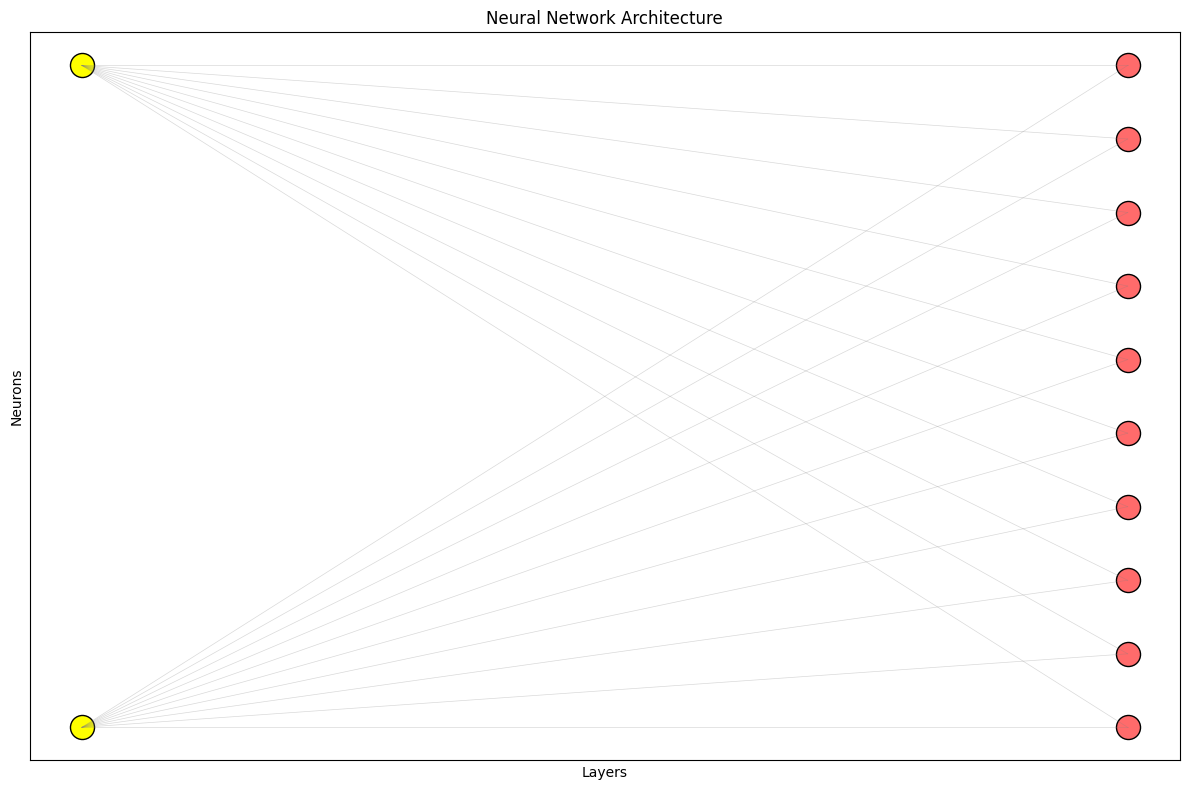

In [183]:
model_ffnn.visualize()

In [184]:
for layer in model_ffnn.layers:
    print("=====Layer======")
    for i in layer.weights:
        print("==Neuron==")
        for j in i:
            print(j.varname)

=====Layer======
==Neuron==
out_add_374eb8a4-c928-4980-aacd-33d6c496f34f
out_add_1a5dd77a-7844-4fe5-a6d4-c1cba3b9cbd9
==Neuron==
out_add_5444e0e1-16cb-4bd0-add9-6cbb6729f235
out_add_98f8586b-e143-4caa-bc3c-430905ce6f68
==Neuron==
out_add_e035b68a-f6ea-4063-8c16-0e60e77328b9
out_add_4520ddcc-c40d-46ea-96c9-74772bcba050
==Neuron==
out_add_86444675-3ae0-467b-be3b-b3e7b11dbdcc
out_add_4a54f265-a864-40b3-a506-2e18e5b4cc2f
==Neuron==
out_add_1aeb8139-e856-4662-aae0-6173c71da7f1
out_add_86b06be5-57dd-47fb-9efb-bdd24cab9eea
==Neuron==
out_add_a56ad36a-5105-49b2-bbb7-4b06ac355a02
out_add_c9ab3f67-82ac-4005-a748-14bc77c2886f
==Neuron==
out_add_8ac2182d-4b09-44f9-bba8-14250d957aea
out_add_9ae4ccf4-6f9e-4be5-ad76-4117097392da
==Neuron==
out_add_ec06c5a2-f034-4398-8e6c-53eff7be9d25
out_add_ac839ad0-e93e-4f82-8192-506a4361a2ac
==Neuron==
out_add_fbf97fb6-da2f-4ad6-bd46-910126685198
out_add_1bc60922-fdac-4a71-ba6b-340f8a0e6360
==Neuron==
out_add_27cce4bd-4c0a-42c8-bbab-1c58aa5183f5
out_add_529a84da-5

In [185]:
for layer in model_ffnn.layers:
    for i in layer.weights:
        for j in i:
            print(j.value)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [186]:
y_pred = model_ffnn.predict(X_test[:10])
for h in y_pred:
    max_index = np.argmax(h)
    print(max_index)

4
4
4
4
4
4
4
4
4
4


In [187]:
model_ffnn.y.shape

(10, 10)

In [188]:
for h in y_test[:10].flatten():
    print(h)

9
6
5
9
6
9
8
8
1
2
